# Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify spectrogram images of DPN+ and DPN- classes.

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

I have a 3000 core Nvdia Titan-X available in my workstation. Without GPU this code would take approximately 48 hours to complete. With GPU it takes about 45 minutes.

Since these are larger (129x27x3) images, it will prove useful to speed up training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
## Load the Data

All spectrogram images are saved inside the 'data' foler. It has two subfolders, namely, "0" and "1". "0" folder contains images representing DPN- class while "1" foler represents DPN+ class.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

### Define Transformations
Before loading the training and testing data some transformations are done on them. For all of the training, validation and test datasets, follwoing transformations are done:
* Resize 129x27 image to 224x224 images as ResNet requires that size input
* All images are normalized to have 0.5 mean and 0.5 standard deviation.
* Images are horizontally flipped with a probability of 0.5. This done to augment the dataset and strengthening the training, validation and testing.

In [4]:
# ### convert data to a normalized torch.FloatTensor
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

### Splitting Dataset
Currently all images are inside the "data" folder. In the following section I split the image data into training, validation and testing groups maintaining a 70:15:15 proportion.

In [5]:
# choose the training and test datasets
# Loading datasets
data_dir = 'data'
trainPercent, valPercent, testPercent = 0.7, 0.15, 0.15 # has to equal to 1
all_data = datasets.ImageFolder(data_dir, transform=transforms)

# obtain training indices that will be used for validation
num_data = len(all_data)
indices = list(range(num_data))
np.random.shuffle(indices)

# Finding the splitting points
split1, split2 = int(np.floor(trainPercent * num_data)), int(np.floor((trainPercent+valPercent) * num_data))
train_idx, valid_idx, test_idx = indices[:split1], indices[split1:split2], indices[split2:]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(all_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(all_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(all_data, batch_size=batch_size, 
    sampler=test_sampler, num_workers=num_workers)

In [6]:
# specify the image classes
classes = ['DPN-', 'DPN+']

### Visualize a Batch of Training Data

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

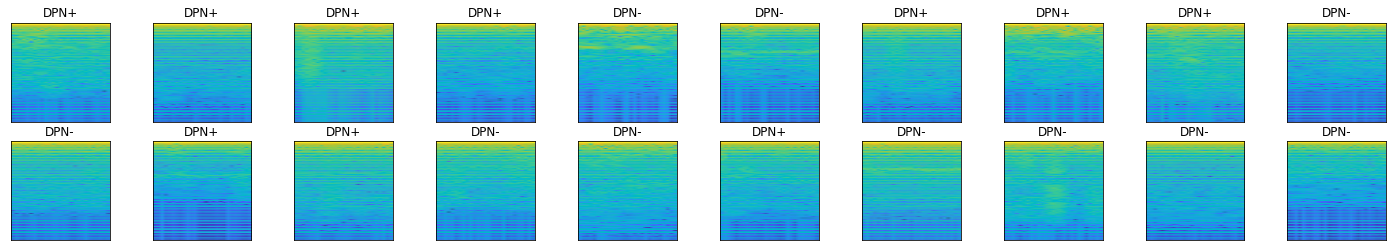

In [8]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

In [9]:
# rgb_img = np.squeeze(images[3])
# channels = ['red channel', 'green channel', 'blue channel']

# fig = plt.figure(figsize = (36, 36)) 
# for idx in np.arange(rgb_img.shape[0]):
#     ax = fig.add_subplot(1, 3, idx + 1)
#     img = rgb_img[idx]
#     ax.imshow(img, cmap='gray')
#     ax.set_title(channels[idx])
#     width, height = img.shape
#     thresh = img.max()/2.5
#     for x in range(width):
#         for y in range(height):
#             val = round(img[x][y],2) if img[x][y] !=0 else 0
#             ax.annotate(str(val), xy=(y,x),
#                     horizontalalignment='center',
#                     verticalalignment='center', size=8,
#                     color='white' if img[x][y]<thresh else 'black')

---
## Transfer Learning


I am using ResNet18. Freezing the entire network but the last fully connected layer. 

In [10]:
from torchvision import models

model = models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [11]:
import torch.nn as nn
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# in_features = 1024
# model.fc = nn.Linear(in_features, 2)


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [12]:
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

I chose Cross-Entropy Loss as loss function and Stochastic Gradient Descent as my optimizer for this problem.  
I set the learning rate to 0.001.

In [13]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)

---
## Train the Network with Learning Rate Variation

Training the model with 200 epochs.  
While training the model weights will be saved whenever the validation loss decreases. In this way, after the training is done, we will have the best model saved.

### Learning Rate Stepping
For this model learning rate is started with 0.001. And every 50 epochos it is scaled by 0.1.

In [14]:
# Setting up learning rate decay
from torch.optim import lr_scheduler
lr_step_size = 50
scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=0.1)

# number of epochs to train the model
n_epochs = 150 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    scheduler.step()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # print Learning rate change
    if epoch%lr_step_size == 1:
        for param_group in optimizer.param_groups:
            print('LR: {}' .format(param_group['lr']) )
            break
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.481522 	Validation Loss: 0.099930
LR: 0.001
Validation loss decreased (inf --> 0.099930).  Saving model ...
Epoch: 2 	Training Loss: 0.468308 	Validation Loss: 0.099136
Validation loss decreased (0.099930 --> 0.099136).  Saving model ...
Epoch: 3 	Training Loss: 0.463345 	Validation Loss: 0.098761
Validation loss decreased (0.099136 --> 0.098761).  Saving model ...
Epoch: 4 	Training Loss: 0.459789 	Validation Loss: 0.097797
Validation loss decreased (0.098761 --> 0.097797).  Saving model ...
Epoch: 5 	Training Loss: 0.459182 	Validation Loss: 0.099351
Epoch: 6 	Training Loss: 0.456399 	Validation Loss: 0.098641
Epoch: 7 	Training Loss: 0.454640 	Validation Loss: 0.097355
Validation loss decreased (0.097797 --> 0.097355).  Saving model ...
Epoch: 8 	Training Loss: 0.454968 	Validation Loss: 0.097445
Epoch: 9 	Training Loss: 0.453360 	Validation Loss: 0.095885
Validation loss decreased (0.097355 --> 0.095885).  Saving model ...
Epoch: 10 	Training Loss: 0.4523

Epoch: 118 	Training Loss: 0.442952 	Validation Loss: 0.095482
Epoch: 119 	Training Loss: 0.443497 	Validation Loss: 0.095707
Epoch: 120 	Training Loss: 0.443016 	Validation Loss: 0.095075
Epoch: 121 	Training Loss: 0.443129 	Validation Loss: 0.095156
Epoch: 122 	Training Loss: 0.443225 	Validation Loss: 0.095720
Epoch: 123 	Training Loss: 0.443240 	Validation Loss: 0.095433
Epoch: 124 	Training Loss: 0.442742 	Validation Loss: 0.095190
Epoch: 125 	Training Loss: 0.443130 	Validation Loss: 0.095332
Epoch: 126 	Training Loss: 0.442223 	Validation Loss: 0.095587
Epoch: 127 	Training Loss: 0.443506 	Validation Loss: 0.095595
Epoch: 128 	Training Loss: 0.444522 	Validation Loss: 0.095277
Epoch: 129 	Training Loss: 0.442755 	Validation Loss: 0.095014
Epoch: 130 	Training Loss: 0.444562 	Validation Loss: 0.095222
Epoch: 131 	Training Loss: 0.444537 	Validation Loss: 0.095420
Epoch: 132 	Training Loss: 0.442424 	Validation Loss: 0.095641
Epoch: 133 	Training Loss: 0.444106 	Validation Loss: 0

###  Load the Model with the Lowest Validation Loss

In [15]:
model.load_state_dict(torch.load('model_cifar.pt'))

---
## Test the Trained Network

Testing trained model on previously unseen data! The model with the lowest validation loss is selected.

In [16]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.096266

Test Accuracy of  DPN-: 62% (1231/1959)
Test Accuracy of  DPN+: 61% (1101/1781)

Test Accuracy (Overall): 62% (2332/3740)


### Visualize Sample Test Results

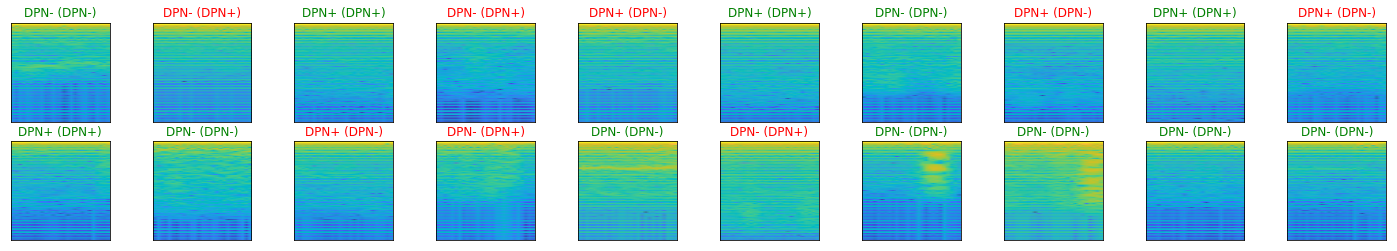

In [17]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))